# Importing the relevant libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

# Data Preprocessing

### Importing the Database

In [4]:
raw_data =pd.read_csv('ml_datasource.csv')
data=raw_data
data.head(5)

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


### Removing Outliers

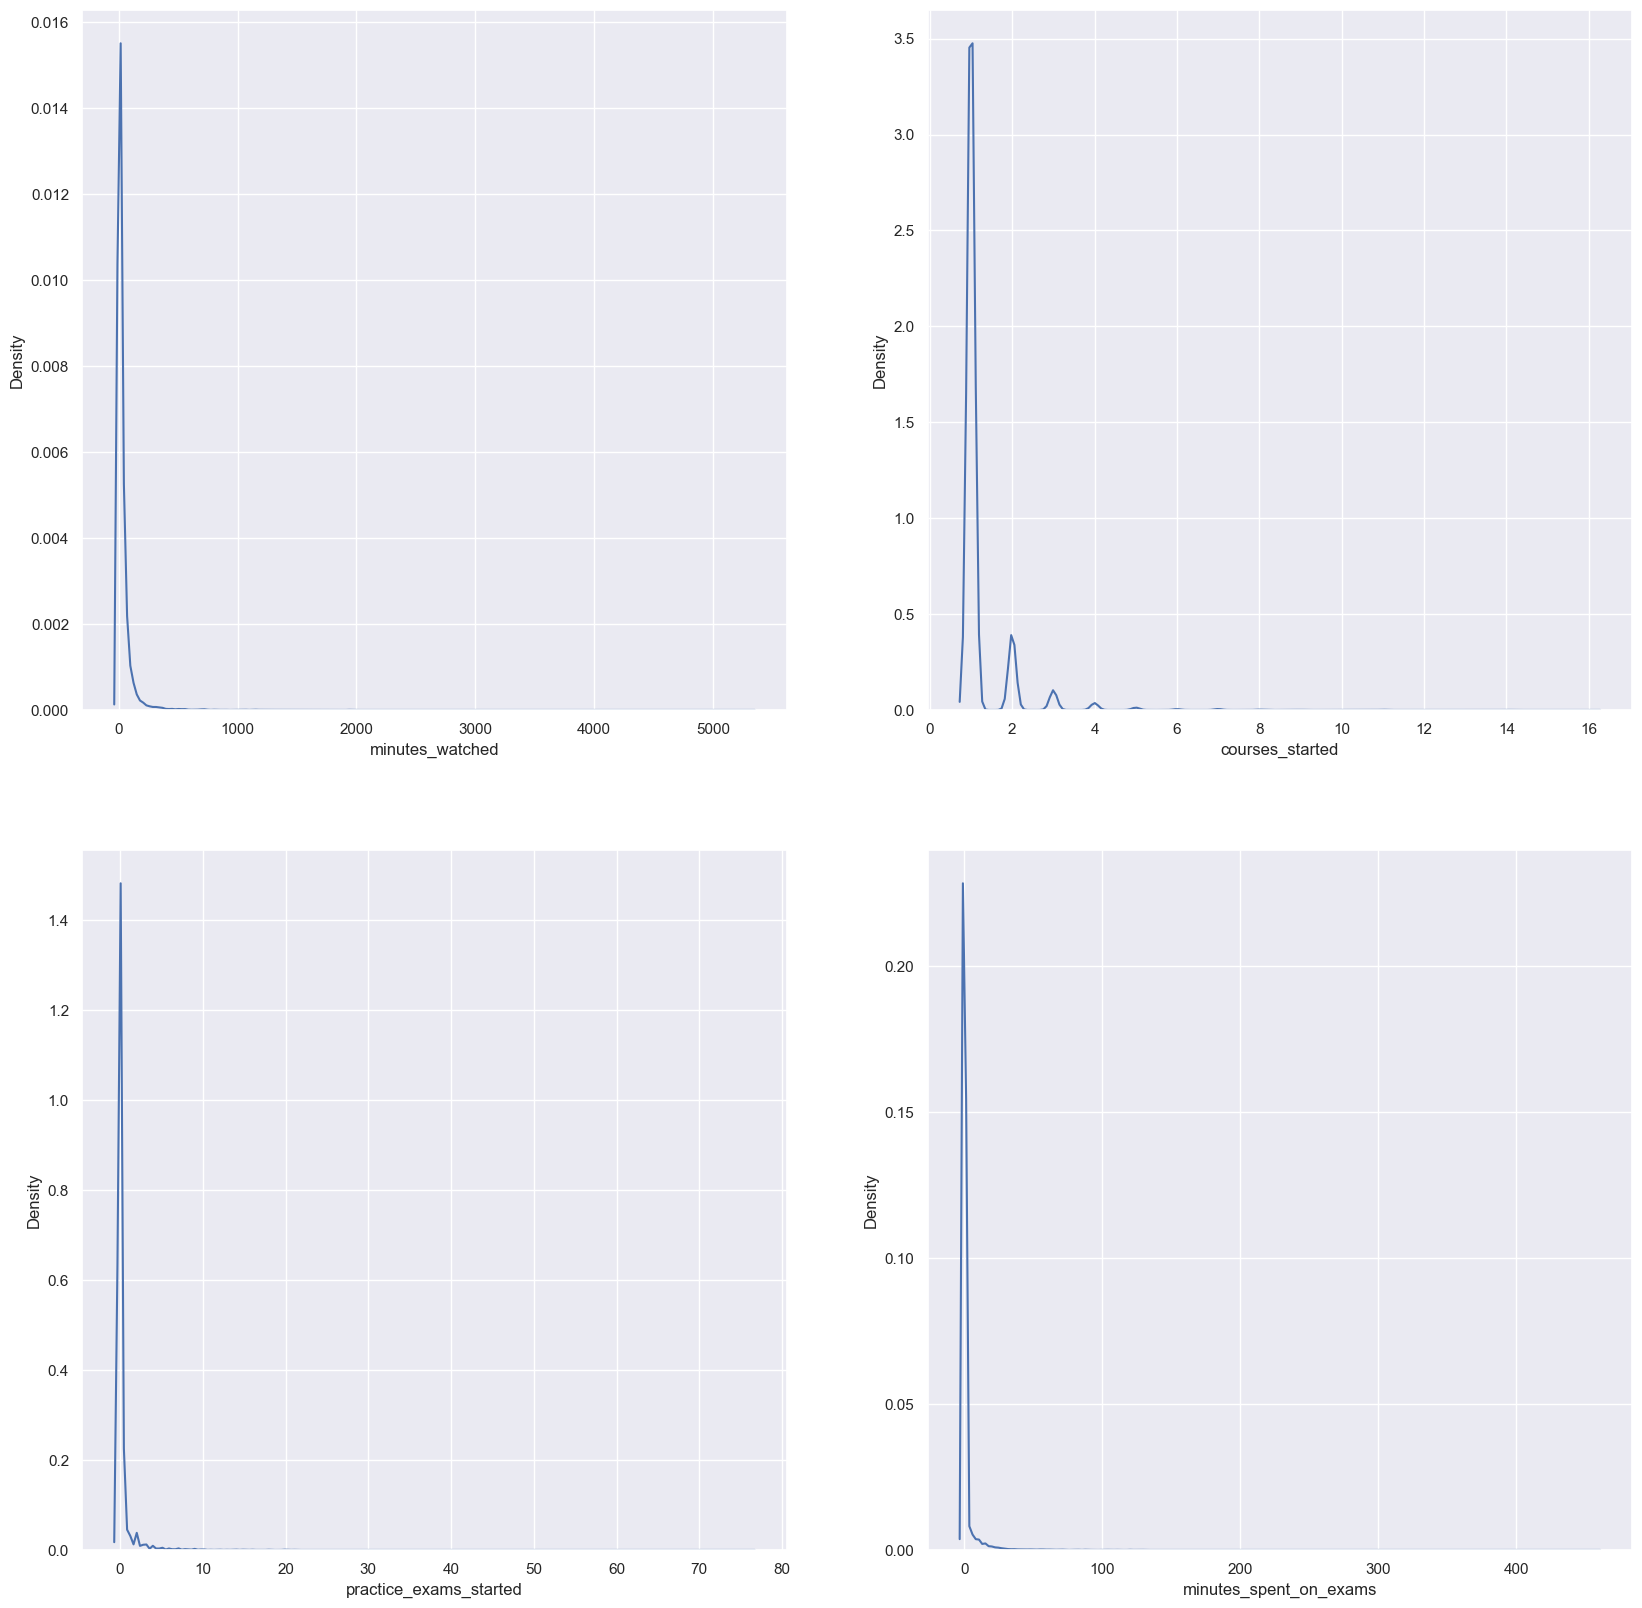

In [5]:
# Step 2: Set the default seaborn theme
sns.set()

# Step 3: Examine the distribution of numerical features using kdeplot
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
# Replace 'minutes_watched', 'courses_started', etc., with the actual column names from your DataFrame
sns.kdeplot(data=data['minutes_watched'], ax=axes[0, 0])
sns.kdeplot(data=data['courses_started'], ax=axes[0, 1])
sns.kdeplot(data=data['practice_exams_started'], ax=axes[1, 0])
sns.kdeplot(data=data['minutes_spent_on_exams'], ax=axes[1, 1])
plt.show()


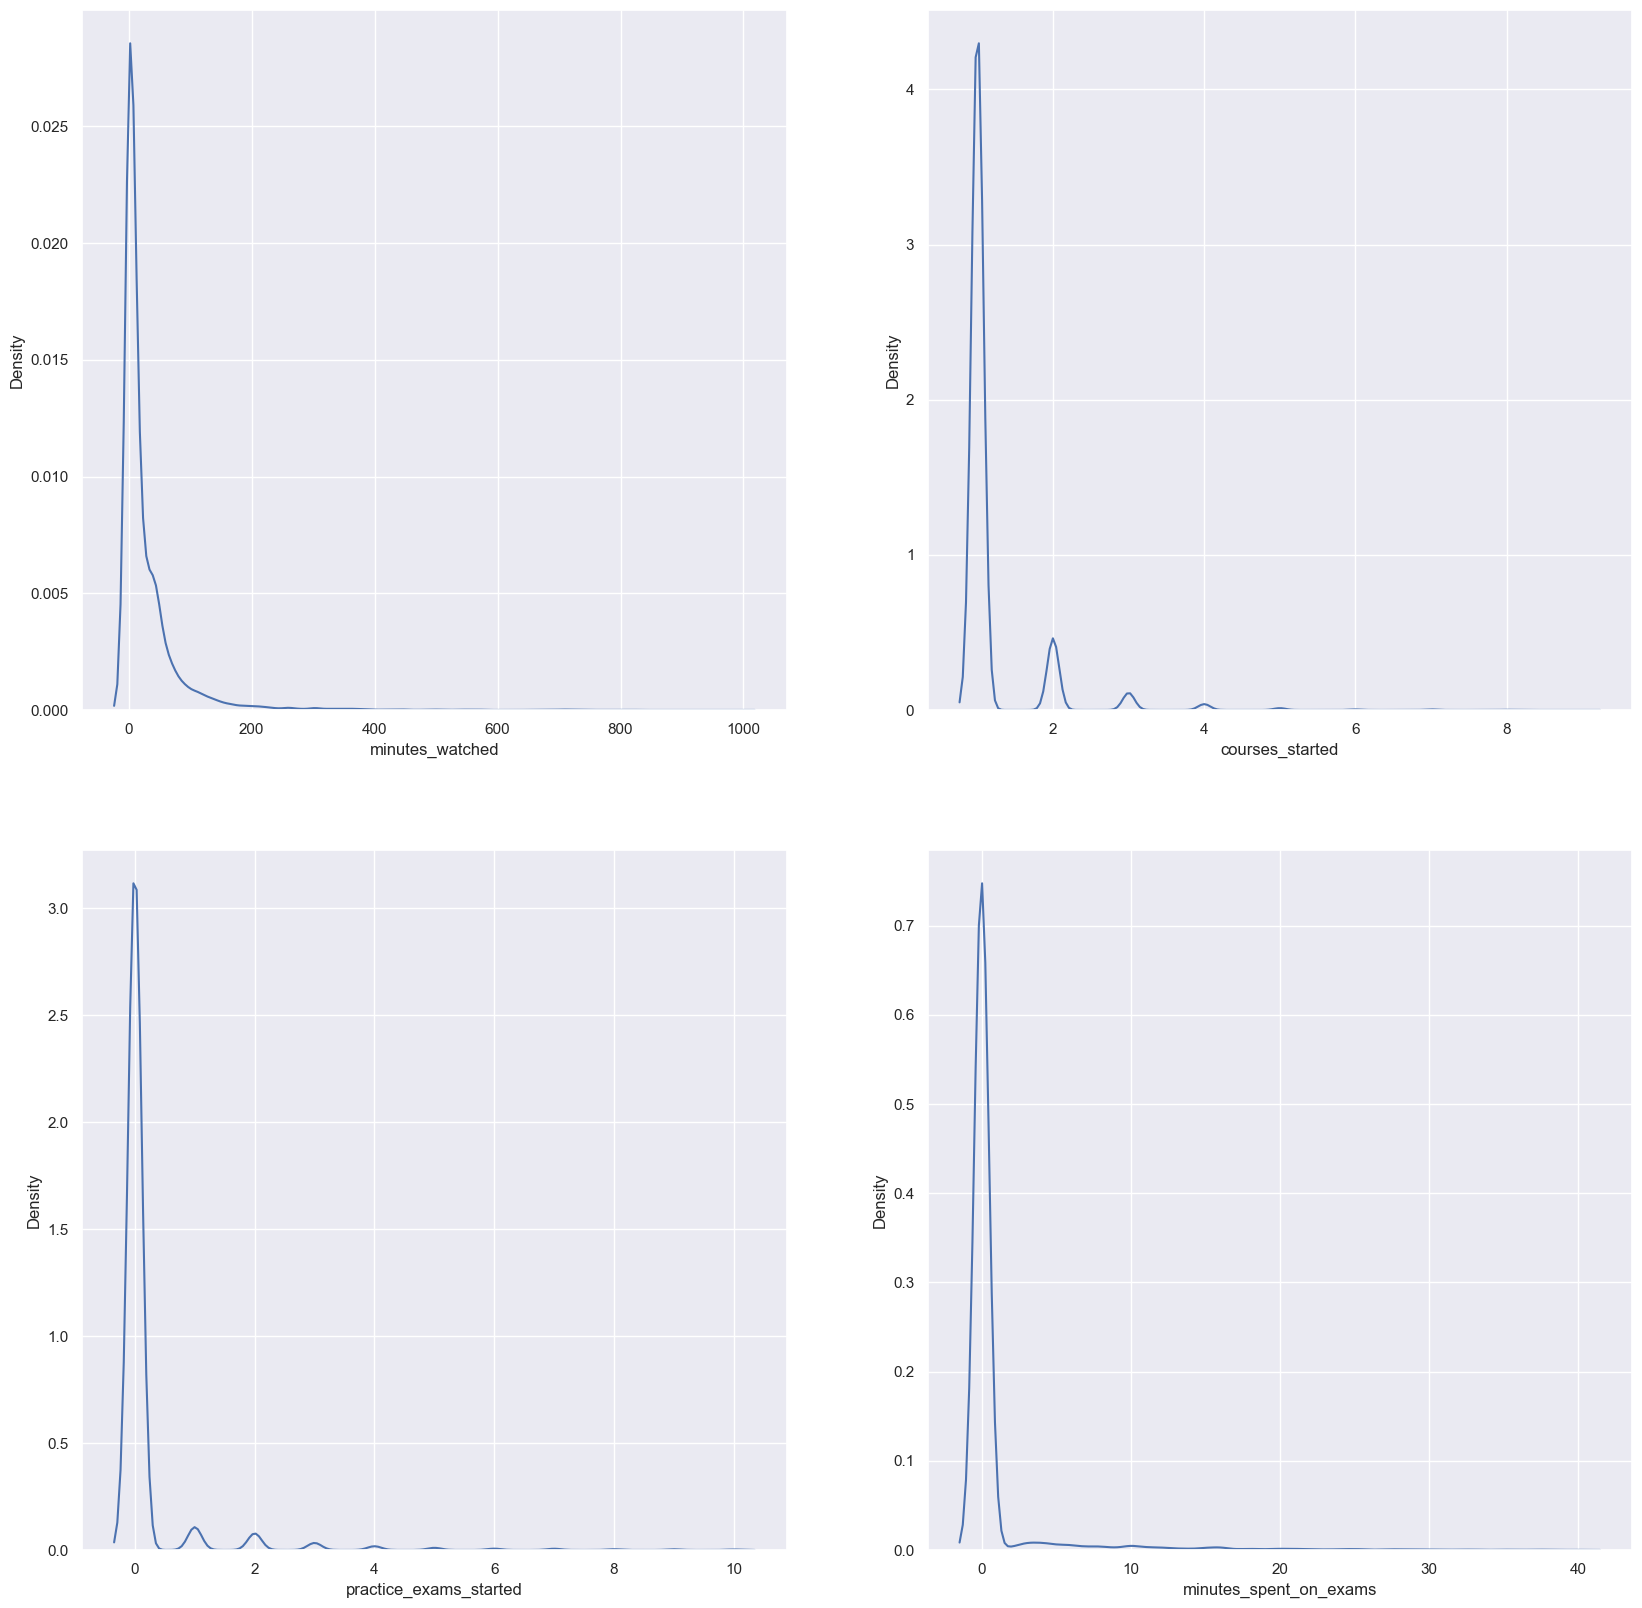

In [6]:
# Step 4: Filter the DataFrame to remove outliers
data_no_outliers = data[
    (data['minutes_watched'] <= 1000) &
    (data['courses_started']<=10)&
    (data['practice_exams_started']<=10)&
    (data['minutes_spent_on_exams']<=40)
]
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
sns.kdeplot(data=data_no_outliers['minutes_watched'], ax=axes[0, 0])
sns.kdeplot(data=data_no_outliers['courses_started'], ax=axes[0, 1])
sns.kdeplot(data=data_no_outliers['practice_exams_started'], ax=axes[1, 0])
sns.kdeplot(data=data_no_outliers['minutes_spent_on_exams'], ax=axes[1, 1])
plt.show()

### Checking for Multicollinearity

In [7]:
# Add constant (for intercept)
X = add_constant(data.drop('purchased', axis=1))  # Dropping the target column ('purchased')
X=X.apply(pd.to_numeric, errors='coerce')
# Drop columns with all NaN values
X = X.dropna(axis=1, how='all')
# Drop rows with any NaN values
X=X.dropna()

In [8]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [9]:
#If any feature still has a VIF value greater than 5, repeat the above steps until all features have a VIF value less than or equal to 5
while True:
    vif_data = calculate_vif(X)
    if vif_data["VIF"].max() > 5:
        feature_to_remove = vif_data.loc[vif_data["VIF"].idxmax(), "Feature"]
        print(f"Removing feature '{feature_to_remove}' with VIF: {vif_data['VIF'].max()}")
        X = X.drop(columns=[feature_to_remove])
    else:
        break

# Display the final VIF values
vif_data = calculate_vif(X)
print(vif_data)

Removing feature 'practice_exams_started' with VIF: 7.590212551347319
Removing feature 'const' with VIF: 6.741498240893207
                  Feature       VIF
0        days_on_platform  2.200183
1         minutes_watched  2.159717
2         courses_started  2.909857
3   practice_exams_passed  3.018533
4  minutes_spent_on_exams  2.998473


### Dealing with NaN Values

In [10]:
# Step 6: Check for missing values
data.isnull().sum()

student_country           9
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_started    0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64

In [11]:
#inspect the records with missing values
nan_records=data.loc[data['student_country'].isnull()]
nan_records

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
311,NaN,88,58.1,1,2,2,11.20,1
337,NaN,86,43.0,1,2,2,12.96,0
526,NaN,70,801.2,3,20,10,64.82,0
556,NaN,121,241.9,2,3,3,21.29,0
806,NaN,64,86.4,1,2,2,4.98,0
1097,NaN,72,67.5,1,2,1,6.27,0
12363,NaN,84,6.2,1,0,0,0.00,0
12633,NaN,78,3.0,1,0,0,0.00,0
16946,NaN,11,8.2,1,0,0,0.00,0


In [12]:
#fill the missing values with NAM in student_country
data_no_nulls = data.fillna({'student_country': 'NAM'})

In [13]:
#Check for missing values
print(data_no_nulls.isnull().sum())

student_country           0
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_started    0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64


### Splitting the Data

In [14]:
#inputs and target
inputs = data_no_nulls.drop('purchased', axis=1)
target = data_no_nulls['purchased']

In [15]:
#Step 3: Split the Data into Training and Testing Sets
x_train, x_test, y_train, y_test = train_test_split(
    inputs, target, 
    test_size=0.2, 
    random_state=365, 
    stratify=target
)
# Print the shapes of the resulting datasets
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (14208, 7)
x_test shape: (3553, 7)
y_train shape: (14208,)
y_test shape: (3553,)


### Encoding the Data

In [16]:
#Step 3: Initialize OrdinalEncoder
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=170)

In [17]:
#Step 4: Fit and Transform Training Data
x_train['student_country_enc'] = enc.fit_transform(x_train['student_country'].to_numpy().reshape(-1, 1))

In [18]:
#Step 5: Transform Test Data
x_test['student_country_enc'] = enc.transform(x_test['student_country'].to_numpy().reshape(-1, 1))

In [19]:
#Step 6: Drop Original student_country Column
x_train = x_train.drop(columns=['student_country'])
x_test=x_test.drop(columns=['student_country'])

In [20]:
#Step 7: Convert DataFrames to numpy ndarrays
x_train_array = np.asarray(x_train, dtype = 'float')
y_train_array = np.asarray(y_train, dtype = 'int')
x_test_array = np.asarray(x_test, dtype = 'float')
y_test_array = np.asarray(y_test, dtype = 'int')
#Purpose: To convert the DataFrames to numpy ndarrays to avoid library incompatibility issues and ensure the data is in the correct format for training machine learning models.

# Creating a Logistic Regression Model

In [21]:
#importing necessary libraries
import statsmodels.api as sm
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix


In [22]:
# Set up the logistic regression model
log_reg = sm.Logit(y_train_array,x_train_array)

In [23]:
# Fit the model
log_reg_results=log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.159888
         Iterations 10


In [24]:
# Display the summary
log_reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                14208
Model:                          Logit   Df Residuals:                    14201
Method:                           MLE   Df Model:                            6
Date:                Fri, 15 Nov 2024   Pseudo R-squ.:                  0.4788
Time:                        12:48:03   Log-Likelihood:                -2271.7
converged:                       True   LL-Null:                       -4359.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0663      0.002    -32.221      0.000      -0.070      -0.062
x2             0.0094      0.001     14.943      0.000       0.008       0.011
x3            -0.1424      0.058     -2.462      0.014      -0.256      -0.029
x4            -0.4227      0.109     -3.862      0.000      -0.637      -0.208
x5             0.5098      0.134      3.796      0.000       0.247       0.773
x6            -0.0639      0.014     -4.682      0.000      -0.091      -0.037
x7             0.0026      0.001      4.281      0.000       0.001       0.004
==============================================================================

Possibly complete quasi-separation: A fraction 0.41 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [25]:
# Make predictions on the test data
y_pred_prob = log_reg_results.predict(x_test_array)

# Convert probabilities to class predictions
y_pred = (y_pred_prob > 0.5).astype(int)

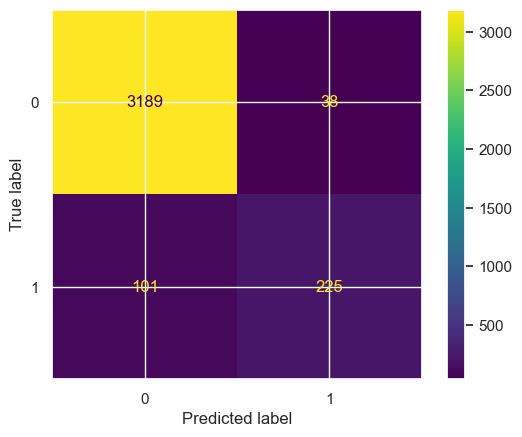

In [26]:
# Create the confusion matrix
cm = confusion_matrix(y_test_array, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Interpretations

-True Negative(TN):
The model predicted correctly 3189 as negative(the student won't purchase sub).<br>
-False Negative(FN):
The model predicted incorrectly 101 as negative(the student won't purchase sub when they actually did).<br>
-False Positive(FP):
The model predicted incorrectly 38 as positive(the student will purchase sub when they actually didn't).<br>
-True positive(TP):
The model predicted correctly 225 as positive(the student will purchase sub).<br>
-Accuracy:96.1% (the predictions are true)<br>
-Precision:85.6%(means that when the model predicts a student will purchase a subscription, it is 85.6% correct )<br>
-Recall:69%(means that the model correctly identifies 69% of all students who will purchase a subscription)<br>
-F1 Score:76.4%(provides a balance between precision and recall)<br>




# Creating a K-Nearest Neighbors Model

In [27]:
#Step 1: Define the Range of Parameters
parameters_knn={'n_neighbors':list(range(1, 51)),
                'weights':['uniform','distance']}

In [29]:
#Step 2: Importing the Necessary Libraries
from sklearn.model_selection import GridSearchCV 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report 

In [30]:
#Step 3: Create an Instance of GridSearchCV
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, parameters_knn, scoring='accuracy', cv=5)

In [31]:
#Step 4: Fit the GridSearchCV Object to the Training Data
grid_search_knn.fit(x_train_array, y_train_array)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [34]:
#Step 5: Find the Best Model
knn_clf = grid_search_knn.best_estimator_
print(f"Best parameters: {grid_search_knn.best_params_}")

Best parameters: {'n_neighbors': 5, 'weights': 'uniform'}


In [35]:
#Step 6: Make Predictions on the Test Data
y_test_pred_knn = knn_clf.predict(x_test_array)

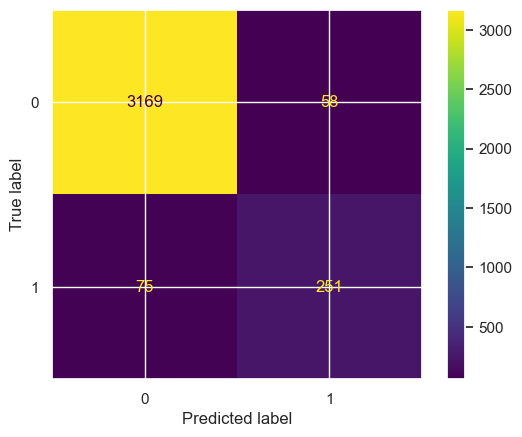

In [36]:
#Step 7: Build and Display the Confusion Matrix
cm_knn = confusion_matrix(y_test_array, y_test_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp_knn.plot()

In [37]:
#Step 8: Generate a Classification Report
report_knn = classification_report(y_test_array, y_test_pred_knn, target_names=['Not Purchased', 'Purchased'])
print(report_knn)

               precision    recall  f1-score   support

Not Purchased       0.98      0.98      0.98      3227
    Purchased       0.81      0.77      0.79       326

     accuracy                           0.96      3553
    macro avg       0.89      0.88      0.88      3553
 weighted avg       0.96      0.96      0.96      3553



# Creating a Support Vector Machines Model

In [38]:
#importing necessary libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

In [41]:
# Create an instance of MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
# Fit and transform the training data
x_train_scaled = scaler.fit_transform(x_train_array)
# Transform the test data
x_test_scaled = scaler.transform(x_test_array)

In [42]:
#Define the Range of Parameters
parameters_svm={'kernel':['linear','poly','rbf'],
                'C':list(range(1, 11)),
                'gamma':['scale','auto']}

In [44]:
#Create an Instance of GridSearchCV
svm=SVC()
grid_search_svm = GridSearchCV(svm, parameters_svm, scoring='accuracy', cv=5)

In [45]:
#Step 4: Fit the GridSearchCV Object to the Training Data
grid_search_svm.fit(x_train_scaled, y_train_array)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy')

In [46]:
#Step 5: Find the Best Model
svm_clf = grid_search_svm.best_estimator_
print(f"Best parameters: {grid_search_svm.best_params_}")

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}


In [47]:
#Step 6: Make Predictions on the Test Data
y_test_pred_svm = svm_clf.predict(x_test_scaled)

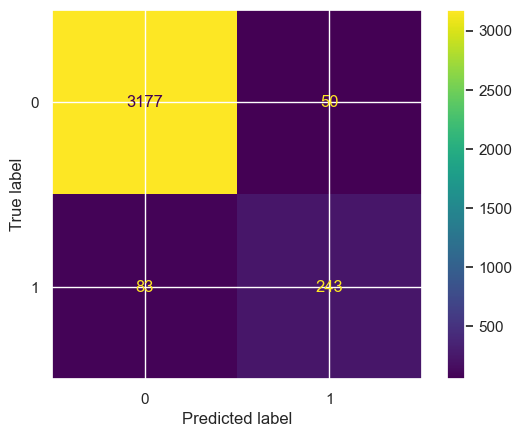

In [48]:
#Step 7: Build and Display the Confusion Matrix
cm_svm = confusion_matrix(y_test_array, y_test_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot()

In [49]:
#Step 8: Generate a Classification Report
report_svm = classification_report(y_test_array, y_test_pred_svm, target_names=['Not Purchased', 'Purchased'])
print(report_svm)

               precision    recall  f1-score   support

Not Purchased       0.97      0.98      0.98      3227
    Purchased       0.83      0.75      0.79       326

     accuracy                           0.96      3553
    macro avg       0.90      0.86      0.88      3553
 weighted avg       0.96      0.96      0.96      3553



# Creating a Decision Trees Model

In [52]:
#importing necessary libraries
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [50]:
#Define the Range of Parameters
parameters_dt = {
    'ccp_alpha': [0, 0.001, 0.002, 0.003, 0.004, 0.005]
}

In [53]:
#Step 3: Create an Instance of GridSearchCV
dt = DecisionTreeClassifier(random_state=365)
grid_search_dt = GridSearchCV(dt, parameters_dt, scoring='accuracy', cv=5)

In [55]:
#Step 4: Fit the GridSearchCV Object to the Training Data
grid_search_dt.fit(x_train_array, y_train_array)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=365),
             param_grid={'ccp_alpha': [0, 0.001, 0.002, 0.003, 0.004, 0.005]},
             scoring='accuracy')

In [56]:
#Step 5: Find the Best Model
dt_clf = grid_search_dt.best_estimator_
print(f"Best parameters: {grid_search_dt.best_params_}")

Best parameters: {'ccp_alpha': 0.003}


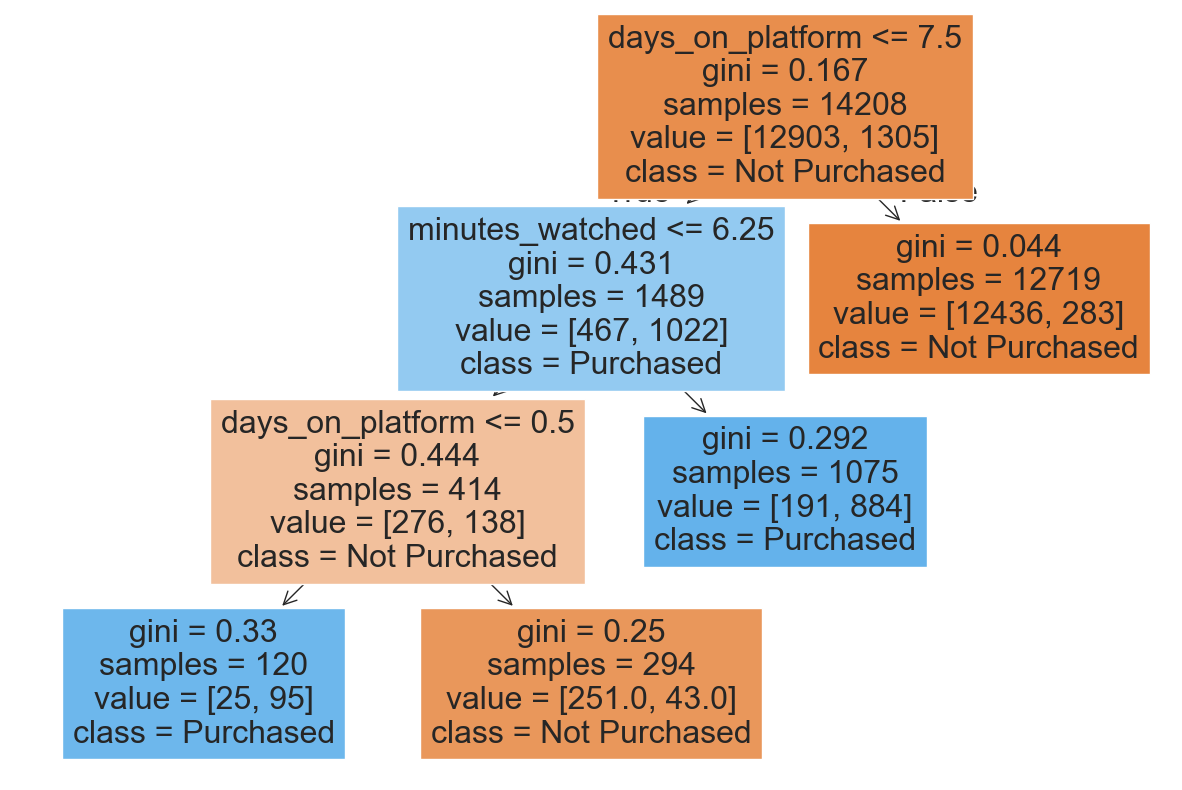

In [57]:
#Step 6: Visualize the Decision Tree
plt.figure(figsize=(15, 10))
plot_tree(dt_clf, filled=True, feature_names=x_train.columns, class_names=['Not Purchased', 'Purchased'])
plt.show()

In [58]:
#Step 7: Make Predictions on the Test Data
y_test_pred_dt = dt_clf.predict(x_test_array)

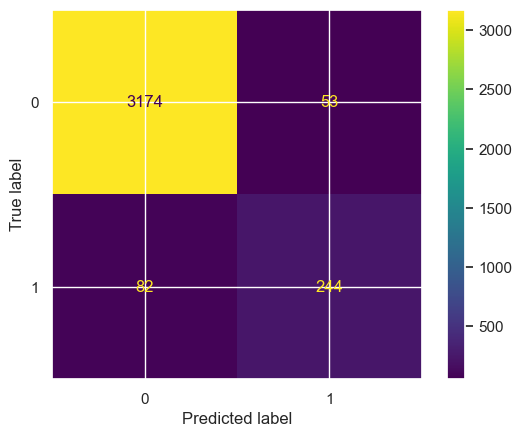

In [59]:
#Step 8: Build and Display the Confusion Matrix
cm_dt = confusion_matrix(y_test_array, y_test_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
disp_dt.plot()

In [60]:
#Step 9: Generate a Classification Report
report_dt = classification_report(y_test_array, y_test_pred_dt, target_names=['Not Purchased', 'Purchased'])
print(report_dt)

               precision    recall  f1-score   support

Not Purchased       0.97      0.98      0.98      3227
    Purchased       0.82      0.75      0.78       326

     accuracy                           0.96      3553
    macro avg       0.90      0.87      0.88      3553
 weighted avg       0.96      0.96      0.96      3553



# Creating a Random Forests Model

In [61]:
#importing necessary libraries
from sklearn.ensemble import RandomForestClassifier

In [62]:
# Assuming best_ccp_alpha is the best ccp_alpha value from the previous task
best_ccp_alpha = grid_search_dt.best_params_['ccp_alpha']

rf_clf = RandomForestClassifier(random_state=365, ccp_alpha=best_ccp_alpha)

In [63]:
#Step 4: Fit the GridSearchCV Object to the Training Data
rf_clf.fit(x_train_array, y_train_array)

RandomForestClassifier(ccp_alpha=0.003, random_state=365)

In [64]:
#make predictions on the test data
y_test_pred_rf = rf_clf.predict(x_test_array)

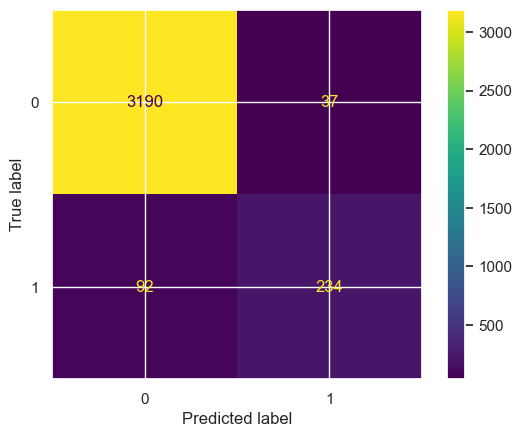

In [65]:
#Step 8: Build and Display the Confusion Matrix
cm_rf = confusion_matrix(y_test_array, y_test_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()

In [67]:
#Step 9: Generate a Classification Report
report_rf = classification_report(y_test_array, y_test_pred_rf, target_names=['Not Purchased', 'Purchased'])
print(report_rf)

               precision    recall  f1-score   support

Not Purchased       0.97      0.99      0.98      3227
    Purchased       0.86      0.72      0.78       326

     accuracy                           0.96      3553
    macro avg       0.92      0.85      0.88      3553
 weighted avg       0.96      0.96      0.96      3553

